In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/My Drive')
from idlmam import *

/content/drive/My Drive/idlmam.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from google.colab import files
files.upload()  # will prompt to upload the kaggle.json file (kaggle.json file downloaded when you req for api from kaggle)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gohgogoh","key":"7dcdea4e9d14f256a828fd2028fe49d8"}'}

In [5]:
import os
# create the Kaggle directory and move the kaggle.json file there
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

# set permissions for the file
os.chmod('/root/.kaggle/kaggle.json', 600) # 600 = cn read and write file oonly for owner (for security)

In [6]:
# 1. download data
!kaggle datasets download -d debashishsau/aslamerican-sign-language-aplhabet-dataset

Dataset URL: https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset
License(s): CC0-1.0
 99% 4.17G/4.20G [00:29<00:00, 128MB/s]
100% 4.20G/4.20G [00:29<00:00, 153MB/s]


In [7]:
# unzip file
!unzip aslamerican-sign-language-aplhabet-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2863).jpg  
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2864).jpg  
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2865).jpg  
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2866).jpg  
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2867).jpg  
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2868).jpg  
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2869).jpg  
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (287).jpg  
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2870).jpg  
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2871).jpg  
  inflating: /content/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2872)

In [8]:
from idlmam import train_network  # Import train_network from idlmam

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import glob # cn use to find file paths for all .jpg file
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
import re

In [ ]:
# use this to check when unsure of where the dataset file/folder is located
import os # so can interact with the file system ==> eg can get filenames
os.listdir("/content/")

['.config',
 'drive',
 'aslamerican-sign-language-aplhabet-dataset.zip',
 'ASL_Alphabet_Dataset',
 'sample_data']

In [9]:
# 2. data preprocessing, make datasets (to organize img + labels), make dataloaders (train in batches, more efficient)

# data augmentation ==> have variation ==> prevent overfitting, higher accuracy
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # resize images to 64x64 ==> smaller ==> reduce computation load ==> faster
    transforms.RandomRotation(15),  # randomly rotate images up to 15 degrees ==> 15 degrees bc such slight changes matches changes in real world when ppl try do sign language
    transforms.RandomHorizontalFlip(),  # images have a 50% chance of being flipped horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # to add slight color variation
    transforms.ToTensor(), # convert img to pytorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize the pixel values of dataset
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# define the dataset paths
train_dataset_path = "/content/ASL_Alphabet_Dataset/asl_alphabet_train"
test_dataset_path = "/content/ASL_Alphabet_Dataset/asl_alphabet_test"

# load training dataset using ImageFolder (inside 'asl_alphabet_train' are folders so use ImageFolder)
train_dataset = ImageFolder(root=train_dataset_path, transform=train_transform)

# to get number of classes (need this for the model output layer later)
num_classes = len(train_dataset.classes)

# map ASL signs to numerical labels (model only learns numbers, not letters)
label_map = {
    "A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "H": 7, "I": 8,
    "J": 9, "K": 10, "L": 11, "M": 12, "N": 13, "O": 14, "P": 15, "Q": 16,
    "R": 17, "S": 18, "T": 19, "U": 20, "V": 21, "W": 22, "X": 23, "Y": 24,
    "Z": 25, "del": 26, "nothing": 27, "space": 28
}

# augment the test images ==> save them to create more test images (currently test dataset only has 1 image per alphabet)
def augment_test_images(folder_path, num_new_images=10): # add 10 new images for each alphabet
    image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))

    if not image_paths:
        print("No images found in test dataset folder.")
        return

    augment_transform = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ])

    for img_path in image_paths:
        image = Image.open(img_path).convert("RGB") # convert and ensure that all images are RGB
        class_label = os.path.basename(img_path).split("_")[0]  # to extract the alphabet from file name (since our filenames are "A_1.jpg", "B_2.jpg", etc.)

        for i in range(num_new_images):
            augmented_image = augment_transform(image)
            new_filename = f"{class_label}_aug_{i}.jpg"
            new_filepath = os.path.join(folder_path, new_filename) # create new filepath containing folder path name and the 'new_filename'

            if not os.path.exists(new_filepath):  # only save augmented img to the new_filepath if the path does not exist yet ==> avoids duplicate augmentation
                augmented_image.save(new_filepath)

    print(f"Added {num_new_images} new images per class to the test set.")

# calling the adding of augemnted images to test dataset
augment_test_images(test_dataset_path)

# have to do this instead of just using ImageFolder bc when open 'asl_alphabet_train', is straight away images.jpg and not sub folders for each alphabet (unlike training)
class CustomTestDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx): # function is to get an image/file name ==> is called by Dataloader when it loads batches
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # to extract the alphabet from file name (since our filenames are "A_1.jpg", "B_2.jpg", etc.)
        label_str = os.path.basename(img_path).split("_")[0]
        label = label_map.get(label_str, -1)

        if label == -1:
            raise ValueError(f"Unknown label: {label_str} in {img_path}")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# now, load test dataset with test transformations
test_dataset = CustomTestDataset(test_dataset_path, transform=test_transform)

# then create DataLoaders
# make them process 32 imgs at a time ==> good speed, dont use too much memory
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) # num_workers ==> use for higher speed since num_workers help speed up the loading of images ==> NOT processing of images
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Added 10 new images per class to the test set.


In [ ]:
# Defining Model
# kernel/filter size = 3 ==> smaller ==> better spatial feature extraction
# stride = 1 ==> move filter 1 pixel at a time ==> preserve more smaller img details + avoid losing details too fast
# padding = 1 ==> need padding so it doesnt get smaller after each convolution ==> if smaller, will lose important details
class HandSignCNN(nn.Module):
    def __init__(self):
        super(HandSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) # input 3 channels (RGB)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # pooling to reduce spatial size of img ==> reduce computation complexity while retaining impt info
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # have 128 feature maps in total, each of height and width 8 * 8 (bc after pooling the 64x64)
        self.fc2 = nn.Linear(512, num_classes)  # output = num classes

    # how the image will flow through this model (aka forward propogation)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # pass through conv --> ReLU --> Pooling
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # flatten before passing in fcl
        x = F.relu(self.fc1(x)) # pass flattened x into fc1 and apply ReLU
        x = self.fc2(x) # the predictions
        return x

In [ ]:
# Initialize model and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if GPU is available
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

model_cnn = HandSignCNN().to(device)

CUDA is available. Using GPU: Tesla T4


In [ ]:
# now, define the loss function and optimizer
loss_func = nn.CrossEntropyLoss() # this is classification task w multiple classes, so CrossEntropyLoss
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001, weight_decay=1e-4) # use Adam for optimizer, also use L2 regularization (weight_decay=1e-4) to prevent overfit

# Training Model
cnn_results = train_network(
    model_cnn,
    loss_func,
    train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    score_funcs={
        'Accuracy': accuracy_score,
        'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=1),
        'Recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro', zero_division=1),
        'F1-score': lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro', zero_division=1)
    },
    device=device,
    epochs=15
)

# Print training results
print(cnn_results)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6972 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

    epoch   total time  train loss  test loss  train Accuracy  test Accuracy  \
0       0   283.194653    1.142014   0.440868        0.638322       0.866883   
1       1   566.472072    0.526183   0.407529        0.830957       0.883117   
2       2   849.106869    0.395978   0.359426        0.872388       0.879870   
3       3  1132.303837    0.322547   0.238732        0.895613       0.925325   
4       4  1416.261126    0.275903   0.469982        0.911330       0.873377   
5       5  1700.853492    0.247877   0.199014        0.920605       0.944805   
6       6  1984.545370    0.228163   0.254346        0.926607       0.938312   
7       7  2267.737025    0.213236   0.259094        0.931825       0.931818   
8       8  2552.448684    0.201389   0.169817        0.935474       0.961039   
9       9  2836.626686    0.190552   0.251429        0.938949       0.938312   
10     10  3118.305416    0.183175   0.243591        0.941194       0.938312   
11     11  3401.533897    0.180334   0.2

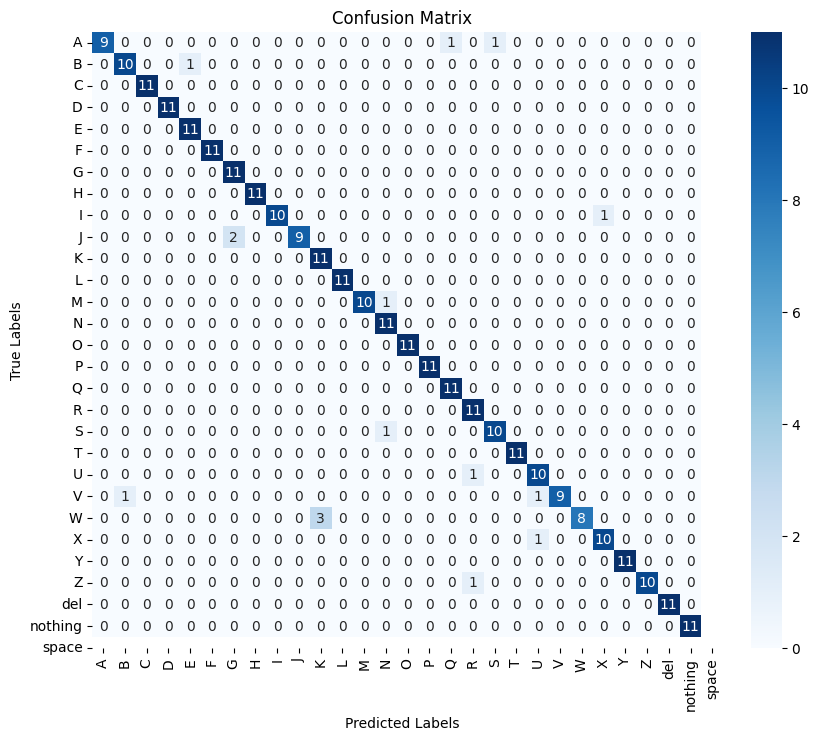

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()  # set model to evaluation mode
    all_preds = [] # empty list to store predicted + actual labels
    all_labels = []

    with torch.no_grad(): # to disable gradient calculation bc we dont need it here --> save memory + computattion
        for images, labels in test_loader: # loop over test dataset
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # pass image in test dataset to the model
            _, preds = torch.max(outputs, 1) # get predicted class label by returning the index of where the probability prediction is highest (eg for a letter, model predicts it is A: 2%, B: 98%. so index is 1 --> model alrd learnt during training that index 1 corresponds to B, so that is how)

            all_preds.extend(preds.cpu().numpy()) # convert predicted tensor to numpy array, then add it to the empty list
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Call the function after training to evaluate
evaluate_model(model_cnn, test_loader, device)